In [2]:
##### Config
from pyspark import SparkConf, SparkContext, HiveContext
import re
import numpy as np
import pandas as pd
import datetime

hive_config_query = '''
set hive.vectorized.execution.enabled=true;
set hive.vectorized.execution.reduce.enabled = true;
set mapreduce.map.memory.mb=4096;
set mapreduce.map.child.java.opts=-Xmx4g;
set mapreduce.task.io.sort.mb=1024;
set mapreduce.reduce.child.java.opts=-Xmx4g;
set mapreduce.reduce.memory.mb=7000;
set mapreduce.reduce.shuffle.input.buffer.percent=0.5;
set mapreduce.input.fileinputformat.split.minsize=536870912;
set mapreduce.input.fileinputformat.split.maxsize=1073741824;
set hive.optimize.ppd=true;
set hive.merge.smallfiles.avgsize=536870912;
set hive.merge.mapredfiles=true;
set hive.merge.mapfiles=true;
set hive.hadoop.supports.splittable.combineinputformat=true;
set hive.exec.reducers.bytes.per.reducer=536870912;
set hive.exec.parallel=true;
set hive.exec.max.created.files=10000000;
set hive.exec.compress.output=true;
set hive.exec.dynamic.partition.mode=nonstrict;
set hive.exec.max.dynamic.partitions=1000000;
set hive.exec.max.dynamic.partitions.pernode=100000;
set io.seqfile.compression.type=BLOCK;
set mapreduce.map.failures.maxpercent=5;
'''
try:
    sc.stop()
except:
    pass
conf = (SparkConf()
        .set("spark.executor.instances", 2)
        .set("spark.driver.maxResultSize", "8g")
        .set('spark.driver.memory','8g')
        .set("spark.executor.memory", '2g')
        .set("spark.yarn.executor.memoryOverhead", 1048)
       )
sc = SparkContext(conf=conf)
hc = HiveContext(sc)

for q in hive_config_query.split(';'):
    try:
        hc.sql(q)
    except:
        pass

In [3]:
 %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Подготовка данных

In [4]:
SAS_Query = '''

%mAssignHadooplibs;

proc sql;

create table hd_ccall.cold_liru_results as 
select
  put(datepart(create_dt),YYMMDD10.) as ymd,
  b.phone_mobile,
  b.utm_campaign,
  b.hl_rk,  
  case when status = 'В работе' then 1 else 0 end as in_work,
  case when a.financial_application_rk is not Null then 1 else 0 end as full_app,
  case when a.decision_dt is not Null then 1 else 0 end as considered,
  case when a.decision_approve_dt is not Null then 1 else 0 end as approve,
  case when a.utilization_dt is not Null then 1 else 0 end as utilization
  
from emart.short_applications_current b 
  left join emart.financial_account_application a on b.financial_application_rk = a.financial_application_rk
where (not b.status in ('Дубль', 'Черный список'))

 and (b.phone_mobile is not Null)
 and b.utm_campaign like 'cold_liru%' 
 and create_dt >= '1Mar2017:0:0:0'dt 
 and create_dt <= '30Jun2017:0:0:0'dt 
;
quit;
'''

In [4]:
df_prod = (hc.sql('''

            select 
              r.ymd as call_ymd,
              r.phone_mobile, 
              max(r.utm_campaign) as utm_campaign,
              max(s.segment_nm) as segment_nm,
              max(r.in_work) as in_work, 
              max(r.full_app) as full_app, 
              max(r.considered) as considered, 
              max(r.approve) as approve, 
              max(r.utilization) as utilization,
              max(
                 named_struct(
                   'ymd', s.ymd,
                   'score',s.seg_score
                   )
                 ).score as score,
              max(s.ymd) as seg_ymd
            from
              prod_ccall.cold_liru_results r
              left join prod_ccall.prod_segments s on substr(s.phone_num,3,20)  = substr(r.phone_mobile, 2,20)
              where
                r.utm_campaign = 'cold_liru'
                and s.ymd between date_add(r.ymd, -7) and date_add(r.ymd, -1)
            group by r.ymd, r.phone_mobile


            ''')
           .toPandas()
          )

df_test = (hc.sql('''

            select 
              r.ymd as call_ymd,
              r.phone_mobile, 
              max(r.utm_campaign) as utm_campaign,
              max(s.segment_nm) as segment_nm,
              max(r.in_work) as in_work, 
              max(r.full_app) as full_app, 
              max(r.considered) as considered, 
              max(r.approve) as approve, 
              max(r.utilization) as utilization,
              max(
                 named_struct(
                   'ymd', s.ymd,
                   'score',s.seg_score
                   )
                 ).score as score,
              max(s.ymd) as seg_ymd
            from
              prod_ccall.cold_liru_results r
              left join prod_ccall.test_segments s on substr(s.phone_num,3,20)  = substr(r.phone_mobile, 2,20)
              where
                r.utm_campaign = 'cold_liru_test'
                and s.ymd between date_add(r.ymd, -7) and date_add(r.ymd, -1)
            group by r.ymd, r.phone_mobile


            ''')
           .toPandas()
          )

### Зависимость от скора по продовым сегментам

/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


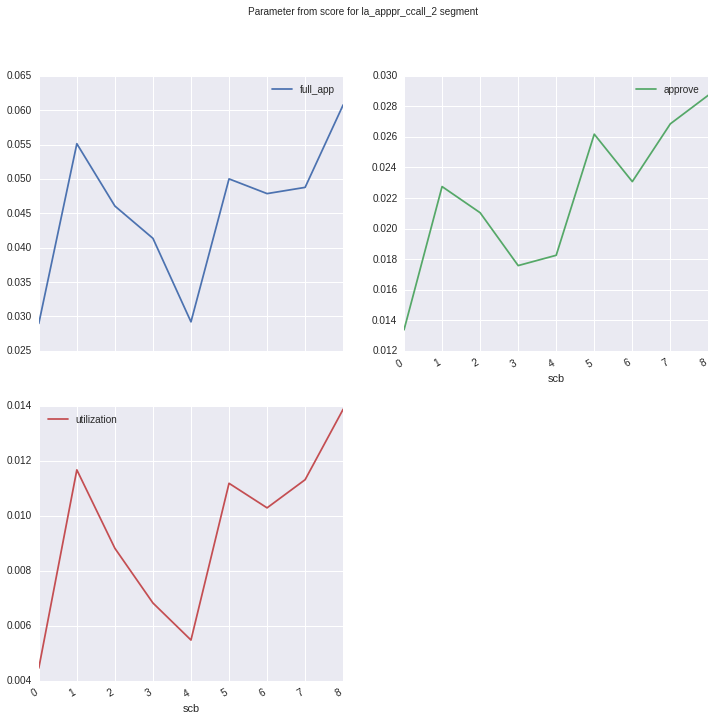

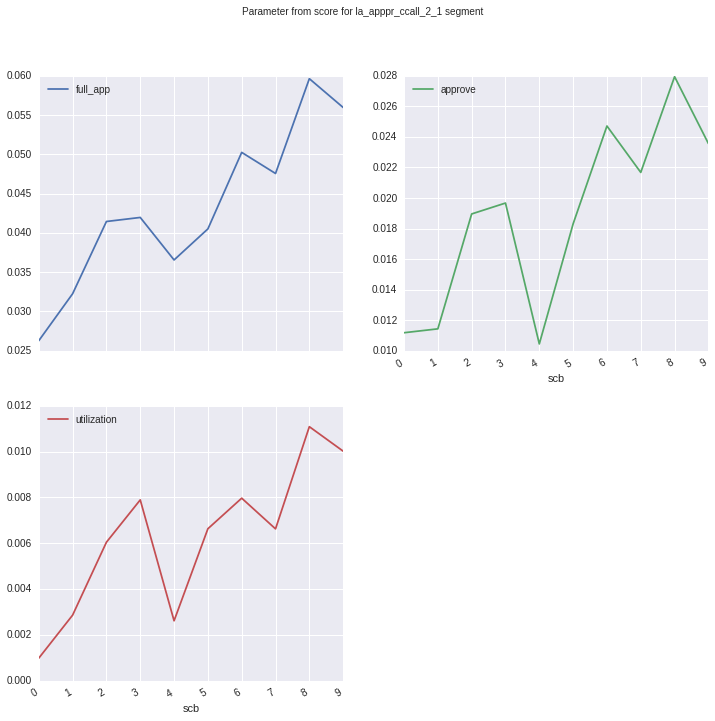

In [5]:
for segment_nm in df_prod['segment_nm'].unique():
    dfm = df_prod[(df_prod['segment_nm'] == segment_nm) & (df_prod['in_work'] == 0)]
    dfm.loc[:,'scb'] = pd.cut(dfm['score'], bins = np.unique(dfm['score'].quantile(np.arange(0,1.1,0.1)).values), labels  = False).values
    dfm.groupby('scb')['full_app','approve','utilization'].mean() \
          .plot(subplots = 1, layout = (2,2) , title  = 'Parameter from score for ' + segment_nm + ' segment', figsize = (12,12))
        #print('-' * 100)

In [6]:
for segment_nm in df_prod['segment_nm'].unique():
    idx = df_prod[(df_prod['segment_nm'] == segment_nm) & (df_prod['in_work'] == 0)].index
    df_prod.loc[idx,'scb'] = pd.cut(df_prod.loc[idx,'score'], bins = np.unique(df_prod.loc[idx,'score'].quantile(np.arange(0,1.2,0.2)).values), labels  = False).values

In [7]:
df1 = df_prod.query('in_work == 0')
df_res = pd.DataFrame(df1.groupby('scb')[['full_app','approve','utilization']].mean().values,columns = ['full_app','approve_from_all','util_from_all'])
#df1.groupby('scb')[['full_app','approve','utilization']].mean()
df_res.loc[:,'approve_from_full_app'] = df1.query('full_app == 1').groupby('scb')['approve'].mean()
df_res.loc[:,'util_from_approve'] = df1.query('approve == 1').groupby('scb')['utilization'].mean()
df_res

,full_app,approve_from_all,util_from_all,approve_from_full_app,util_from_approve
0,0.034520,0.014062,0.004406,0.407343,0.313305
1,0.042358,0.019282,0.007413,0.455208,0.384439
2,0.042281,0.020020,0.007589,0.473504,0.379061
3,0.048495,0.023355,0.009156,0.481600,0.392027
4,0.057919,0.026959,0.011443,0.465455,0.424479


### Зависимость от скора по тестовым сегментам

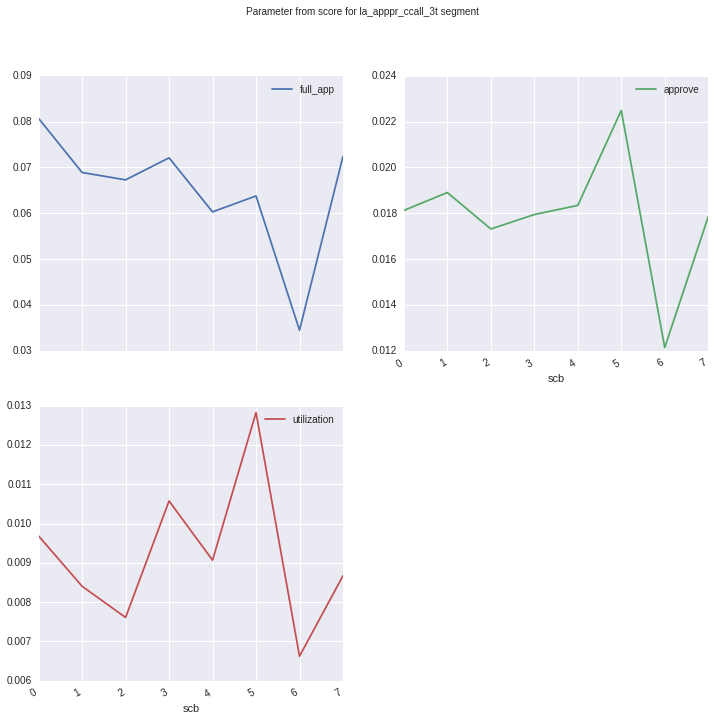

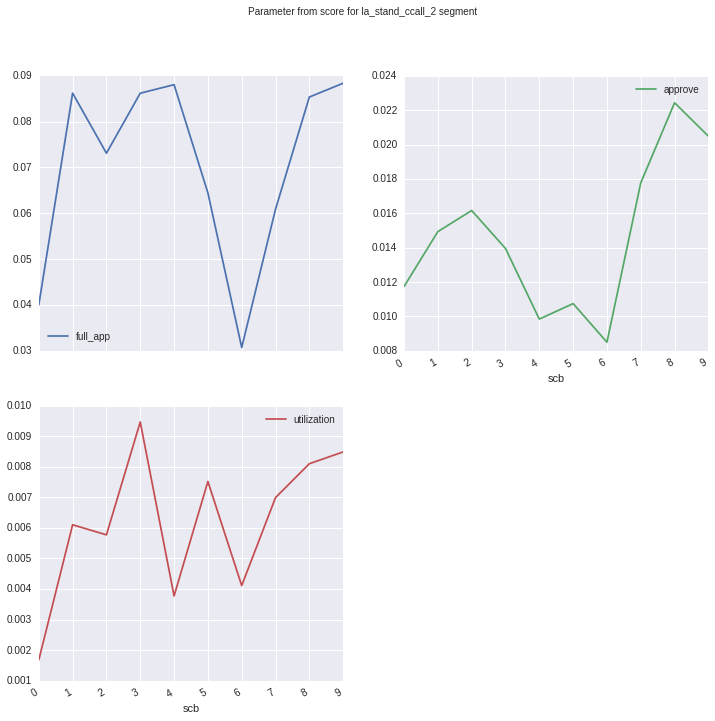

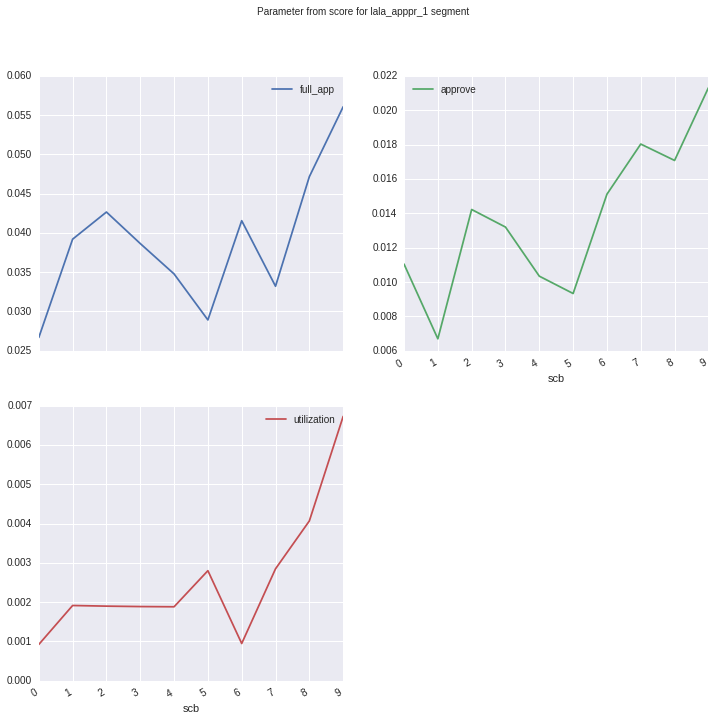

In [8]:
for segment_nm in df_test['segment_nm'].unique():
    dfm = df_test[(df_test['segment_nm'] == segment_nm) & (df_test['in_work'] == 0)]
    dfm.loc[:,'scb'] = pd.cut(dfm['score'], bins = np.unique(dfm['score'].quantile(np.arange(0,1.1,0.1)).values), labels  = False).values
    dfm.groupby('scb')['full_app','approve','utilization'].mean() \
          .plot(subplots = 1, layout = (2,2) , title  = 'Parameter from score for ' + segment_nm + ' segment', figsize = (12,12))
        #print('-' * 100)

In [9]:
for segment_nm in df_test['segment_nm'].unique():
    idx = df_test[(df_test['segment_nm'] == segment_nm) & (df_test['in_work'] == 0)].index
    df_test.loc[idx,'scb'] = pd.cut(df_test.loc[idx,'score'], bins = np.unique(df_test.loc[idx,'score'].quantile(np.arange(0,1.2,0.2)).values), labels  = False).values

df2 = df_test.query('in_work == 0')
df_res2 = pd.DataFrame(df2.groupby('scb')[['full_app','approve','utilization']].mean().values,columns = ['full_app','approve_from_all','util_from_all'])
#df1.groupby('scb')[['full_app','approve','utilization']].mean()
df_res2.loc[:,'approve_from_full_app'] = df2.query('full_app == 1').groupby('scb')['approve'].mean()
df_res2.loc[:,'cnt'] = df2.groupby('scb')['approve'].count()
df_res2.loc[:,'util_from_approve'] = df2.query('approve == 1').groupby('scb')['utilization'].mean()
df_res2

,full_app,approve_from_all,util_from_all,approve_from_full_app,cnt,util_from_approve
0,0.066910,0.015192,0.005955,0.227050,21327,0.391975
1,0.067768,0.016484,0.006879,0.243243,24569,0.417284
2,0.072440,0.011965,0.005535,0.165169,12286,0.462585
3,0.054546,0.017474,0.007935,0.320350,23063,0.454094
4,0.065074,0.017698,0.007556,0.271967,14691,0.426923
